In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import textstat
from collections import defaultdict, Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import gensim
import pyLDAvis.gensim
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import spacy 
from textstat import flesch_reading_ease
import re

In [32]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielwidjaja/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/danielwidjaja/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/danielwidjaja/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [3]:
news = pd.read_excel("Dataset/wikileaks_parsed.xlsx")
news.head()

,PDF Path,Text
0,1.pdf,Pristina Airport – Possible administrative irr...
1,1.pdf,Investigative details\n\nIn his/her interviews...
2,10.pdf,"""An interoffice memorandum providing an “outst..."
3,10.pdf,"""Allegation 2 & 3:\n\n(Specifically, three of ..."
4,10.pdf,"""When asked about this in interview, the Divis..."


Text(0.5, 1.0, 'Number of characters')

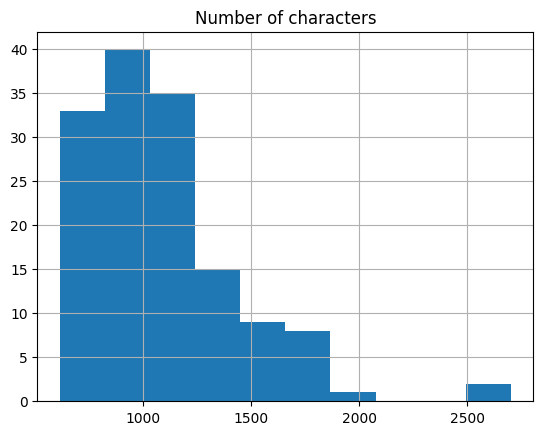

In [4]:
#Histogram of Characters 
news['Text'].str.len().hist()
plt.title("Number of characters")

In [5]:
def plot_word_nums_hist(text):
    text.str.split().map(lambda x: len(x)).hist()

Text(0.5, 1.0, 'Number of words')

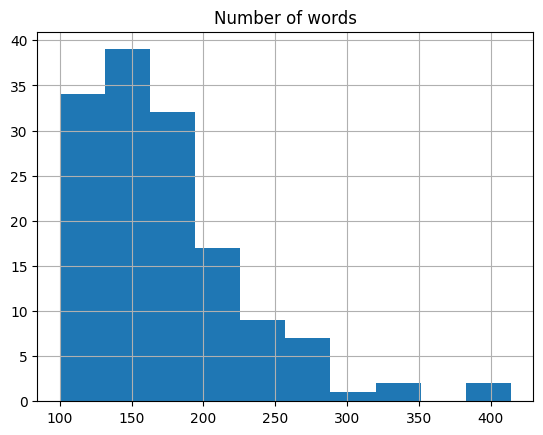

In [6]:
plot_word_nums_hist(news['Text'])
plt.title("Number of words")

In [7]:
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

Text(0.5, 1.0, 'Top Stopword Count')

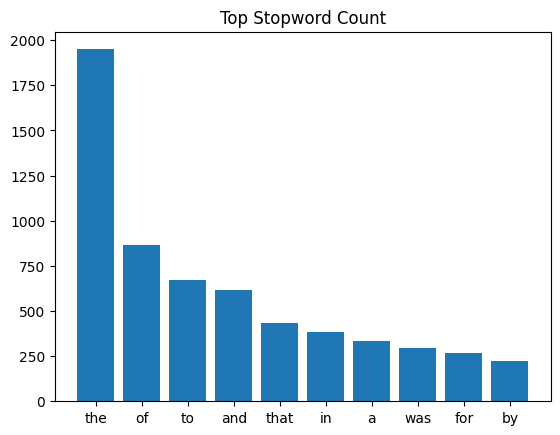

In [8]:
plot_top_stopwords_barchart(news['Text'])
plt.title('Top Stopword Count')

In [9]:
def plot_top_non_stopwords_barchart(text):
    stop = set(stopwords.words('english'))
    
    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter([word.strip('.,!?;"\'').lower() for word in corpus])
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:60]:
        if word not in stop and word != '–':
            x.append(word)
            y.append(count)
    
    sns.barplot(x=y, y=x)

Text(0.5, 1.0, 'Top non-stopwords Count')

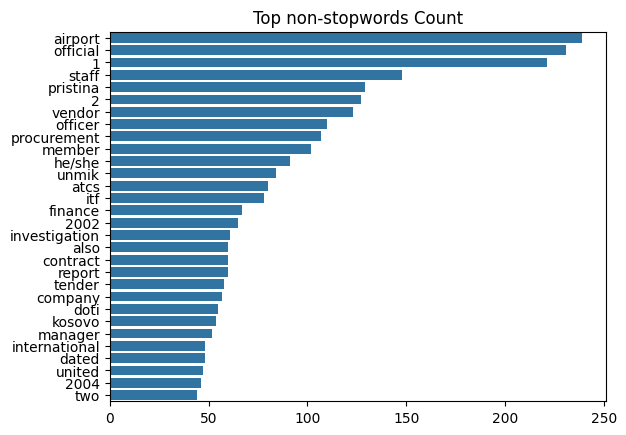

In [10]:
plot_top_non_stopwords_barchart(news['Text'])
plt.title("Top non-stopwords Count")

In [11]:
def plot_top_ngrams_barchart(text, n=2):
    stop = set(stopwords.words('english'))

    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i if word.lower() not in stop]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams = _get_top_ngram(corpus, n)[:10]
    x, y = map(list, zip(*top_n_bigrams))
    sns.barplot(x=y, y=x)

Text(0.5, 1.0, 'Top Bigram Count')

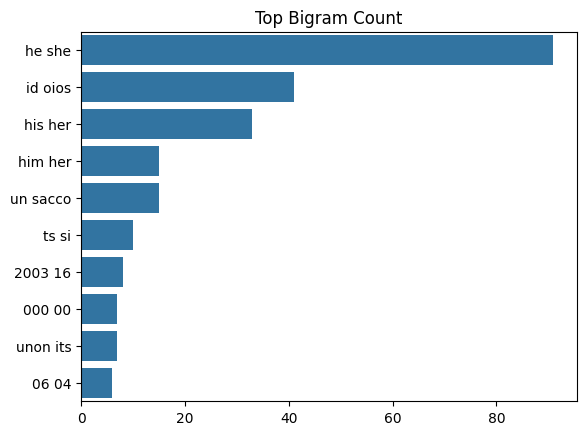

In [12]:
plot_top_ngrams_barchart(news['Text'],2)
plt.title("Top Bigram Count")

Text(0.5, 1.0, 'Top Trigram Count')

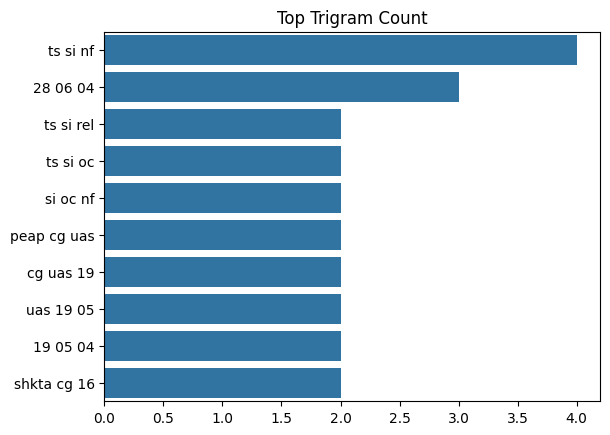

In [13]:
plot_top_ngrams_barchart(news['Text'],3)
plt.title("Top Trigram Count")

In [14]:
def preprocess_news(text):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for news in text:
        words = re.findall(r'\b\w+\b', news.lower())
        words = [lem.lemmatize(w) for w in words if len(w) > 2 and w not in stop]
        corpus.append(words)
    return corpus

In [15]:
def get_lda_objects(text):
    corpus=preprocess_news(text)
    
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
    return vis

In [16]:
lda_model, bow_corpus, dic = get_lda_objects(news['Text'])
lda_model.show_topics()

[(0,
  '0.013*"official" + 0.012*"staff" + 0.010*"unon" + 0.009*"bid" + 0.008*"oios" + 0.008*"member" + 0.008*"tender" + 0.007*"document" + 0.007*"evaluation" + 0.006*"vendor"'),
 (1,
  '0.017*"staff" + 0.015*"member" + 0.008*"unep" + 0.008*"officer" + 0.007*"dra" + 0.007*"procurement" + 0.007*"email" + 0.006*"within" + 0.005*"vendor" + 0.005*"oios"'),
 (2,
  '0.024*"official" + 0.015*"atcs" + 0.014*"airport" + 0.012*"staff" + 0.011*"2002" + 0.010*"cash" + 0.008*"airline" + 0.007*"itf" + 0.007*"non" + 0.007*"pristina"'),
 (3,
  '0.029*"airport" + 0.019*"official" + 0.016*"pristina" + 0.014*"vendor" + 0.012*"unmik" + 0.011*"procurement" + 0.010*"officer" + 0.008*"pillar" + 0.008*"company" + 0.008*"doti"')]

In [17]:
plot_lda_vis(lda_model, bow_corpus, dic)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.129001 -0.075228       1        1  42.102744
2     -0.121084 -0.091775       2        1  24.566091
0      0.011288  0.059013       3        1  18.574315
1     -0.019206  0.107990       4        1  14.756850, topic_info=            Term        Freq       Total Category  logprob  loglift
281         atcs   73.000000   73.000000  Default  30.0000  30.0000
157        staff  126.000000  126.000000  Default  29.0000  29.0000
13       airport  219.000000  219.000000  Default  28.0000  28.0000
1055        cash   35.000000   35.000000  Default  27.0000  27.0000
1683        unon   31.000000   31.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
185       report    7.974178   53.380938   Topic4  -5.5274   0.0122
22       company    6.919974   65.911604   Topic4  -5.6692  -0.3404
122        would    6.377379   36.198308   Topic4  -5.7509   0.1772
147     official    7.221211  225.622372   Topic4  -5.6266  -1.5284
14    allegation    6.231943   37.348021   Topic4  -5.7739   0.1229

[286 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1281      3  0.933864          135
229       1  0.740479         1999
229       2  0.059238         1999
229       3  0.148096         1999
229       4  0.029619         1999
...     ...       ...          ...
122       2  0.414384        would
122       3  0.276256        would
122       4  0.165754        would
1734      4  0.651860        wrote
367       1  0.882997  yugoslavian

[466 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2])

In [18]:
print(preprocess_news(news['Text'])[0])

['pristina', 'airport', 'possible', 'administrative', 'irregularity', 'regarding', 'tender', 'procedure', 'involving', 'vendor', 'vendor', 'allegation', 'two', 'company', 'owner', 'took', 'part', 'least', 'three', 'time', 'airport', 'tender', 'background', 'information', 'kosovo', 'citizen', 'vendor', 'vendor', 'representative', 'owner', 'director', 'pristina', 'based', 'vendor', 'also', 'shareholder', 'pristina', 'ljubljana', 'based', 'company', 'vendor', 'company', 'residence', 'address', 'pristina', 'vendor', 'vendor', 'submitted', 'three', 'time', '2003', 'tender', 'supply', 'mounting', 'sonic', 'system', 'fire', 'station', 'building', 'winner', 'vendor', '530', 'followed', 'vendor', '620', 'third', 'company', 'vendor', 'provide', 'price', 'offer', 'cabling', 'flat', 'display', 'information', 'system', 'fids', 'winner', 'vendor', '919', 'followed', 'vendor', '248', 'two', 'competitor', 'vendor', 'vendor', 'offered', 'price', 'euro', '702', 'euro', '045', 'purchase', 'fixing', 'cram

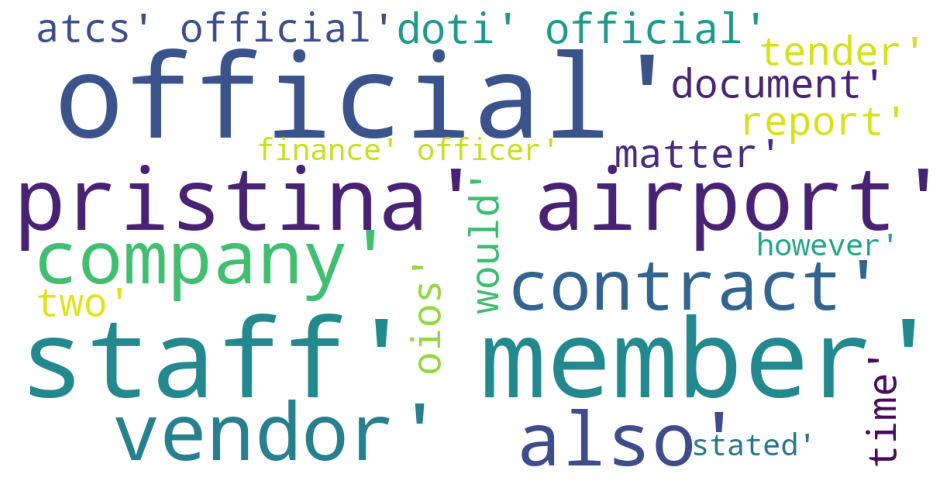

In [19]:
def plot_wordcloud(text):
    corpus = preprocess_news(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=20,
        max_font_size=50, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()
    
plot_wordcloud(news['Text'])

<Axes: >

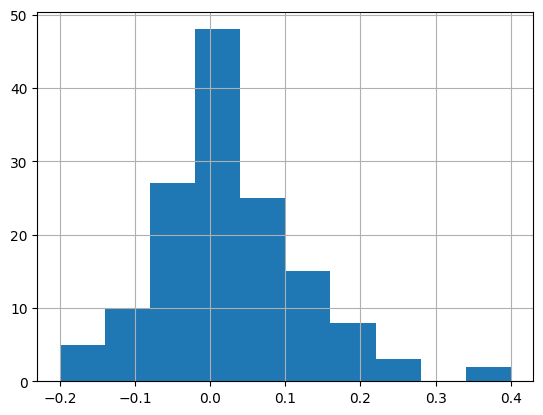

In [20]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

news['polarity_score']=news['Text'].apply(lambda x : polarity(x))
news['polarity_score'].hist()

<BarContainer object of 3 artists>

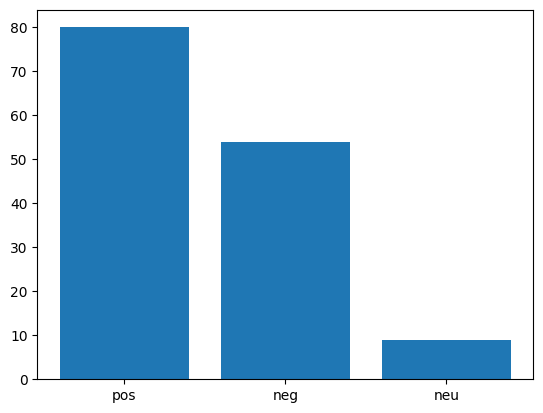

In [21]:
def sentiment(x):
    if x<0:
        return 'neg'
    elif x==0:
        return 'neu'
    else:
        return 'pos'

news['polarity']=news['polarity_score'].map(lambda x: sentiment(x))

plt.bar(news.polarity.value_counts().index,
        news.polarity.value_counts())

In [22]:
news[news['polarity']=='neg']['Text'].head()

0     Pristina Airport – Possible administrative irr...
4     "When asked about this in interview, the Divis...
6     "At paragraph 4 of the Cargo Apron Extension e...
8     "METHODOLOGY\n\nThis investigation was conduct...
12    "Description\n\nThis is a Secret US National S...
Name: Text, dtype: object

In [23]:
news[news['polarity']=='pos']['Text'].head()

1    Investigative details\n\nIn his/her interviews...
2    "An interoffice memorandum providing an “outst...
3    "Allegation 2 & 3:\n\n(Specifically, three of ...
5    "INVESTIGATION DETAILS\n\nThis part of the inv...
9    "Allegation 4:\n\n(Specifically, that the Vend...
Name: Text, dtype: object

In [24]:
nlp = spacy.load('en_core_web_sm')

In [25]:
def ner(text):
    doc=nlp(text)
    return [X.label_ for X in doc.ents]

ent=news['Text'].apply(lambda x : ner(x))
ent=[x for sub in ent for x in sub]

counter=Counter(ent)
count=counter.most_common()

<Axes: >

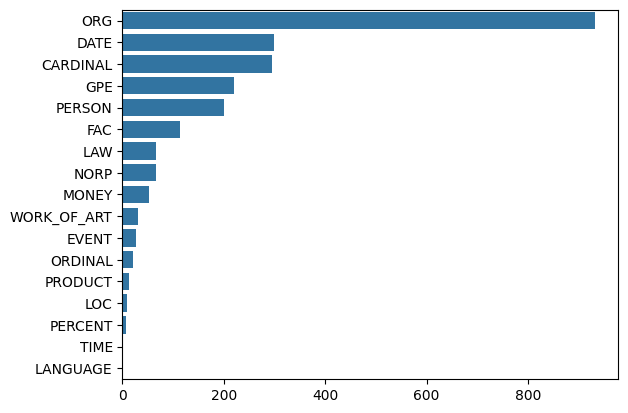

In [26]:
x,y=map(list,zip(*count))
sns.barplot(x=y,y=x)


In [27]:
def plot_most_common_named_entity_barchart(text, entity="PERSON"):
    def _get_ner(text,ent):
        doc=nlp(text)
        return [X.text for X in doc.ents if X.label_ == ent and len(text)>1]

    entity_filtered=text.apply(lambda x: _get_ner(x,entity))
    entity_filtered=[i for x in entity_filtered for i in x]
    
    counter=Counter(entity_filtered)
    x,y=map(list,zip(*counter.most_common(10)))
    sns.barplot(x=y, y=x).set_title(entity)

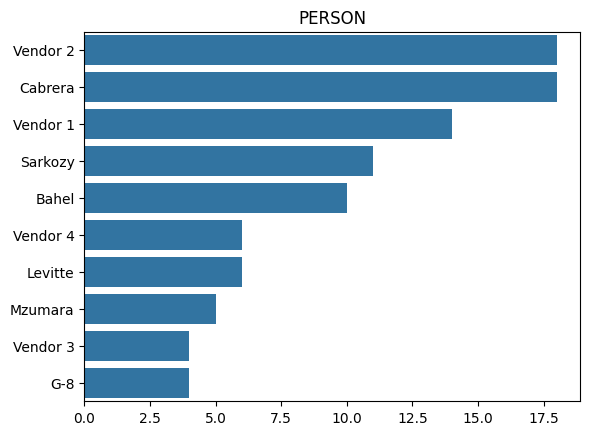

In [28]:
plot_most_common_named_entity_barchart(news['Text'], entity="PERSON")

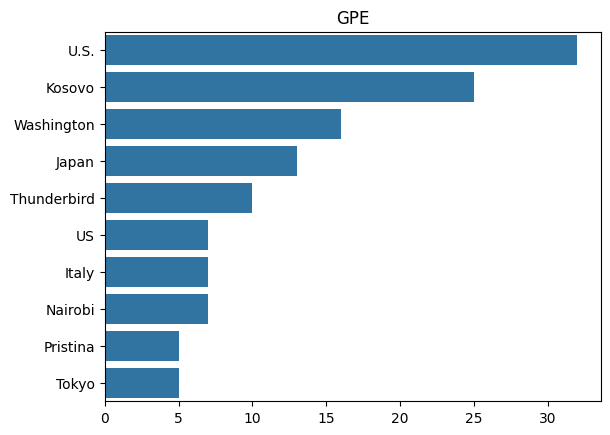

In [29]:
plot_most_common_named_entity_barchart(news['Text'], entity="GPE")

In [30]:
def plot_parts_of_speach_barchart(text):

    def _get_pos(text):
        pos=nltk.pos_tag(word_tokenize(text))
        pos=list(map(list,zip(*pos)))[1]
        return pos
    
    tags=text.apply(lambda x : _get_pos(x))
    tags=[x for l in tags for x in l]
    counter=Counter(tags)
    x,y=list(map(list,zip(*counter.most_common(20))))
    
    sns.barplot(x=y,y=x)

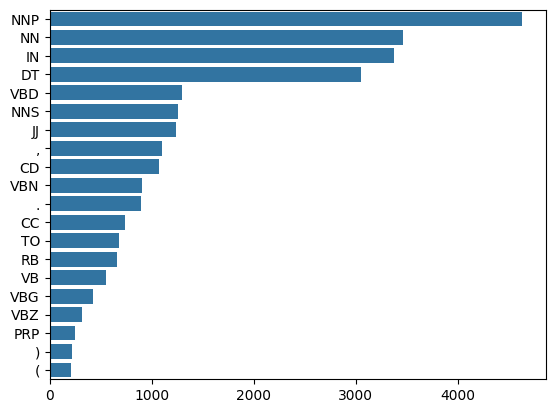

In [33]:
plot_parts_of_speach_barchart(news['Text'])

In [250]:
def plot_most_common_part_of_speach_barchart(text, part_of_speach='NN'):
    def _filter_pos(text):
        pos_type=[]
        pos=nltk.pos_tag(word_tokenize(text))
        for word,tag in pos:
            if tag==part_of_speach:
                pos_type.append(word)
        return pos_type
    words=text.apply(lambda x : _filter_pos(x))
    words=[x for l in words for x in l]
    counter=Counter(words)
    x,y=list(map(list,zip(*counter.most_common(20))))
    sns.barplot(x=y,y=x).set_title(part_of_speach)

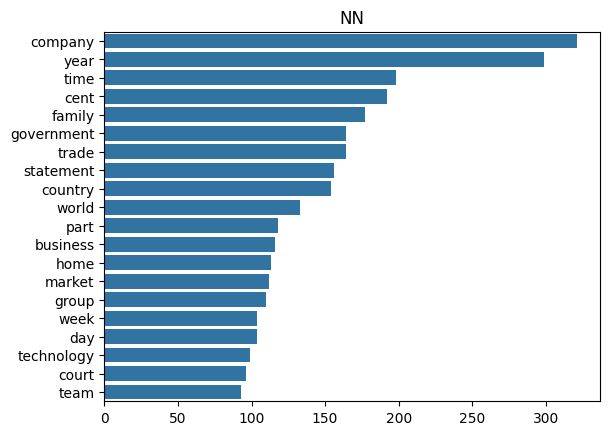

In [249]:
plot_most_common_part_of_speach_barchart(news['Text'])

In [173]:
def plot_text_complexity_histogram(text):
    text.apply(lambda x : flesch_reading_ease(x)).hist()

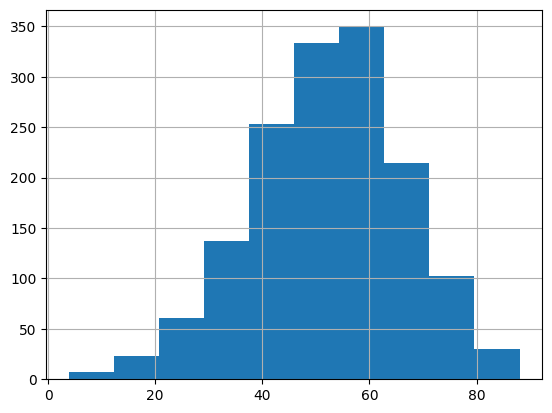

In [174]:
plot_text_complexity_histogram(news['Text'])